# MAST30034 Project 2

## Machine learning model comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import  RandomForestRegressor
from sklearn.ensemble import  AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
#!pip install xgboost
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#!pip install tensorflow
#!pip install keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import cross_val_score

import statsmodels.api as sm

In [2]:
gpd_domain = pd.read_csv('../data/curated/df_model.csv')
X_train = pd.read_csv('../data/curated/X_train.csv')
y_train = pd.read_csv('../data/curated/y_train.csv')
X_test = pd.read_csv('../data/curated/X_valid.csv')
y_test = pd.read_csv('../data/curated/y_valid.csv')
X_pred = pd.read_csv('../data/curated/X_predict.csv')

X_train = X_train.drop(['Unnamed: 0', 'Unnamed: 0.1'],  axis = 1)
X_test = X_test.drop(['Unnamed: 0', 'Unnamed: 0.1'],  axis = 1)
X_pred = X_pred.drop(['Unnamed: 0', 'Unnamed: 0.1'],  axis = 1)
y_train = y_train.drop(['Unnamed: 0'],  axis = 1)
y_test = y_test.drop(['Unnamed: 0'],  axis = 1)

print('The shape of x train is', X_train.shape)
print('The shape of y train is', y_train.shape)
print('The shape of x valid is', X_test.shape)
print('The shape of y valid is', y_test.shape)
print('The shape of x prediction is', X_pred.shape)

The shape of x train is (3634, 13)
The shape of y train is (3634, 1)
The shape of x valid is (909, 13)
The shape of y valid is (909, 1)
The shape of x prediction is (4543, 13)


In [3]:
X_train['Income'] = X_train['Income2022']
X_train['popu'] = X_train['popu2022']
X_train = X_train.drop(['popu2022', 'Income2022'],  axis = 1)

X_test['Income'] = X_test['Income2022']
X_test['popu'] = X_test['popu2022']
X_test = X_test.drop(['popu2022', 'Income2022'],  axis = 1)

X_pred['Income'] = X_pred['Income2025']
X_pred['popu'] = X_pred['popu2025']
X_pred = X_pred.drop(['popu2025', 'Income2025'],  axis = 1)

### Feature selections by OLS

In [4]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X_train)
#Fitting sm.OLS model
Feature_sel = sm.OLS(y_train,X_1).fit()
Feature_sel.pvalues.sort_values(ascending=True)

Income          3.415990e-114
Bedrooms         1.028789e-95
Bathrooms        5.584058e-86
hos_count        1.341941e-19
Postcode         4.384867e-09
Longitude        1.446617e-07
Parkings         4.194783e-05
const            4.931055e-05
stop_count       1.015356e-04
Latitude         6.785341e-04
SA2_code         5.622877e-03
popu             2.252219e-02
school_count     3.048866e-02
distance         9.810772e-01
dtype: float64

#### only remain the features with p-value<0.05

In [5]:
#Backward Elimination
cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
X_train = X_train[cols]
X_test = X_test[cols]
print(selected_features_BE)

['Postcode', 'Bedrooms', 'Bathrooms', 'Parkings', 'SA2_code', 'Longitude', 'Latitude', 'hos_count', 'stop_count', 'school_count', 'Income', 'popu']


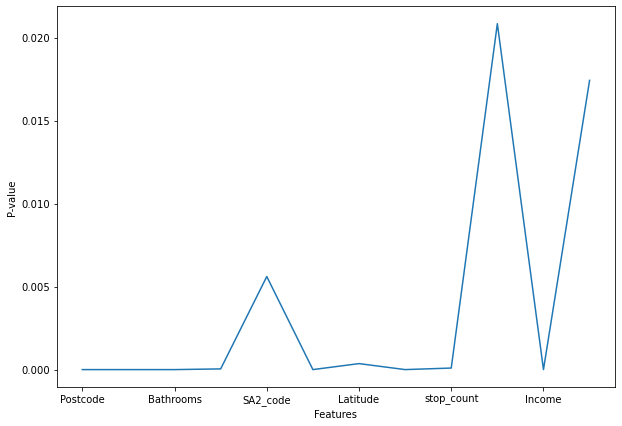

In [6]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X_train)
#Fitting sm.OLS model
Feature_sel = sm.OLS(y_train,X_1).fit()
# remove const col
fea_importance = Feature_sel.pvalues[1:]


fig = plt.figure(figsize =(10, 7))
plt.xlabel("Features")
plt.ylabel("P-value")
fea_importance.plot()
plt.show()

In [7]:
fea_importance.sort_values(ascending=True)

Income          2.757800e-120
Bedrooms         9.557031e-96
Bathrooms        3.091978e-86
hos_count        1.309427e-19
Postcode         2.217028e-12
Longitude        1.925254e-10
Parkings         4.185605e-05
stop_count       9.359499e-05
Latitude         3.610416e-04
SA2_code         5.606430e-03
popu             1.742740e-02
school_count     2.084349e-02
dtype: float64

## StandardScaler

In [8]:
def scale_datasets(x_train, x_test):
    standard_scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        standard_scaler.fit_transform(X_train),
        columns=X_train.columns
    )
    X_test_scaled = pd.DataFrame(
        standard_scaler.transform(X_test),
        columns = X_test.columns
    )
    return X_train_scaled, X_test_scaled
X_train_scaled, X_test_scaled = scale_datasets(X_train, X_test)

## Modeling with hyperparameter tuning

In [9]:
# a dataframe to collect models and errors
models_summary = pd.DataFrame([],
                              columns=['model_name', 
                                       'prediction_score',
                                       'mean_absolute_percentage_error'
                                      ])

### Baseline model (LinearRegression)

In [10]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_model_predicted = lr_model.predict(X_test)
lr_model_score = lr_model.score(X_test, y_test)

mae = mean_absolute_percentage_error(y_test, lr_model_predicted)
models_summary = models_summary.append({
    'model_name': 'Baselinemodel',
    'prediction_score': lr_model_score,
    'mean_absolute_percentage_error': mae
}, ignore_index=True)

models_summary = models_summary.sort_values('prediction_score', ascending=False)

### RandomForestRegressor

In [11]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels 
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=35, verbose=2)

In [12]:
RFRModel=RandomForestRegressor(**rf_random.best_params_) 
RFRModel.fit(X_train, y_train)
RFRModel_predicted = RFRModel.predict(X_test)
RFRModel_score = RFRModel.score(X_test, y_test)

mae = mean_absolute_percentage_error(y_test, RFRModel_predicted)
models_summary = models_summary.append({
    'model_name': RFRModel.__class__.__name__,
    'prediction_score': RFRModel_score,
    'mean_absolute_percentage_error' : mae
}, ignore_index=True)

models_summary = models_summary.sort_values('prediction_score', ascending=False)

<ipython-input-12-c91826f315c6>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFRModel.fit(X_train, y_train)


### AdaBoostRegressor

In [13]:
ADB_model = AdaBoostRegressor()
ADB_model.fit(X_train, y_train)
ADB_model_predicted = ADB_model.predict(X_test)
ADB_model_score = ADB_model.score(X_test, y_test)

# find Mean Absolute Error
mae = mean_absolute_percentage_error(y_test, ADB_model_predicted)
models_summary = models_summary.append({
    'model_name': ADB_model.__class__.__name__,
    'prediction_score': ADB_model_score,
    'mean_absolute_percentage_error' : mae
}, ignore_index=True)

models_summary = models_summary.sort_values('prediction_score', ascending=False)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### XGBRegressor

In [14]:
model = XGBRegressor()
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]
## Hyper Parameter Optimization
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }
# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)
random_cv.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=5)

In [15]:
XGBR_model = XGBRegressor(**random_cv.best_params_)

XGBR_model.fit(X_train, y_train)
XGBR_model_predicted = XGBR_model.predict(X_test)
XGBR_model_score = XGBR_model.score(X_test, y_test)

mae = mean_absolute_percentage_error(y_test, XGBR_model_predicted)
models_summary = models_summary.append({
    'model_name': XGBR_model.__class__.__name__,
    'prediction_score': XGBR_model_score,
    'mean_absolute_percentage_error' : mae
}, ignore_index=True)

models_summary = models_summary.sort_values('prediction_score', ascending=False)

### GradientBoostingRegressor

In [16]:
GBR = GradientBoostingRegressor()
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [100,500,1000, 1500],
              'max_depth'    : [4,6,8,10]
             }
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [100, 500, 1000, 1500],
                         'subsample': [0.9, 0.5, 0.2, 0.1]})

In [17]:
gbr_model = GradientBoostingRegressor(**grid_GBR.best_params_)
gbr_model.fit(X_train, y_train)

GBR_model_predicted = gbr_model.predict(X_test)
GBR_model_score = gbr_model.score(X_test, y_test)

mae = mean_absolute_percentage_error(y_test, GBR_model_predicted)
models_summary = models_summary.append({
    'model_name': gbr_model.__class__.__name__,
    'prediction_score': GBR_model_score,
    'mean_absolute_percentage_error' : mae
}, ignore_index=True)

models_summary = models_summary.sort_values('prediction_score', ascending=False)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### prediction vs true value of GradientBoosting

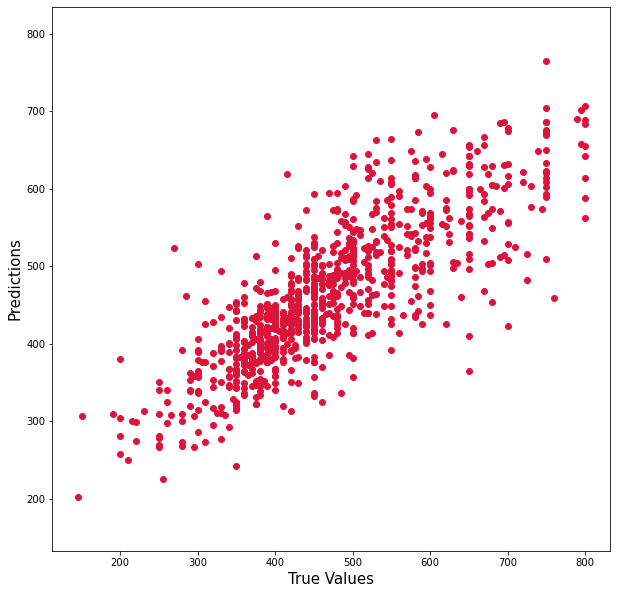

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, GBR_model_predicted, c='crimson')

plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.savefig('../plots/GBR_pred_plot.png')
plt.show()

## Artificial Neural Networks for Regression

In [19]:
### Sandardization of data ###
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X_train)
TargetVarScalerFit=TargetVarScaler.fit(y_train)

PredictorScalerFit=PredictorScaler.fit(X_test)
TargetVarScalerFit=TargetVarScaler.fit(y_test)

In [20]:
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15, 20]
    epoch_list  =   [5, 10, 50, 100]

    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', 
                            activation='relu'))
            # Defining the Second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
            # Compiling the model
            model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = 
                      epochs_trial, verbose=0)
            MAPE = mean_absolute_percentage_error(y_test, model.predict(X_test))
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 
                  'epochs:',epochs_trial, 'Error:', MAPE)
            
            SearchResultsData=SearchResultsData.append(
                pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 
                                    MAPE]],columns=['TrialNumber', 'Parameters', 'Error'] ))
    return(SearchResultsData)
# Calling the function
ResultsData=FunctionFindBestParams(X_train, y_train, X_test, y_test)

1 Parameters: batch_size: 5 - epochs: 5 Error: 0.2190459890418039
2 Parameters: batch_size: 5 - epochs: 10 Error: 0.19985457734040216
3 Parameters: batch_size: 5 - epochs: 50 Error: 0.2002377955603541
4 Parameters: batch_size: 5 - epochs: 100 Error: 0.2528695061910965
5 Parameters: batch_size: 10 - epochs: 5 Error: 0.20683831872766067
6 Parameters: batch_size: 10 - epochs: 10 Error: 0.19914295774957622
7 Parameters: batch_size: 10 - epochs: 50 Error: 0.19859150371053277
8 Parameters: batch_size: 10 - epochs: 100 Error: 0.2754186528437627
9 Parameters: batch_size: 15 - epochs: 5 Error: 0.2028882271216242
10 Parameters: batch_size: 15 - epochs: 10 Error: 0.9945517868297226
11 Parameters: batch_size: 15 - epochs: 50 Error: 0.9724596147863922
12 Parameters: batch_size: 15 - epochs: 100 Error: 0.19998707187208864
13 Parameters: batch_size: 20 - epochs: 5 Error: 0.2100531474904716
14 Parameters: batch_size: 20 - epochs: 10 Error: 0.19956075933432674
15 Parameters: batch_size: 20 - epochs: 50

In [21]:
models_summary = models_summary.append({
    'model_name': 'ANN',
    'prediction_score': 'NaN',
    'mean_absolute_percentage_error' : 0.21
}, ignore_index=True)

In [22]:
models_summary = models_summary.append({
    'model_name': 'GLM',
    'prediction_score': 'NaN',
    'mean_absolute_percentage_error' : 0.145445
}, ignore_index=True)

models_summary['mean_absolute_percentage_error'] = pd.to_numeric(
    models_summary['mean_absolute_percentage_error'], downcast="float")
models_summary = models_summary.sort_values('mean_absolute_percentage_error', ascending=True)

In [23]:
models_summary

,model_name,prediction_score,mean_absolute_percentage_error
0,GradientBoostingRegressor,0.660173,0.110329
2,RandomForestRegressor,0.634099,0.112296
1,XGBRegressor,0.654537,0.112425
6,GLM,NaN,0.145445
3,Baselinemodel,0.419933,0.149277
4,AdaBoostRegressor,0.408678,0.173755
5,ANN,NaN,0.210000


In [24]:
models_summary.to_csv('../data/curated/model.csv')

#### Now use the mean prediction of GradientBoosting, Randomforest, XGB to calculate the estimated top 10 suburbs with highest predicted growth rate.

In [25]:
df_result = pd.DataFrame({'Postcode': gpd_domain['Postcode'],
                   '2022_prices': gpd_domain['Prices'],
                   '2025_prices_XGB': XGBR_model.predict(X_pred[cols]),
                          '2025_prices_RandomForest': RFRModel.predict(X_pred[cols]),
                         '2025_prices_GradientBoosting': gbr_model.predict(X_pred[cols])})
df_result

,Postcode,2022_prices,2025_prices_XGB,2025_prices_RandomForest,2025_prices_GradientBoosting
0,3002,395.0,423.832977,486.362761,502.027265
1,3002,750.0,678.984802,701.618145,695.664636
2,3002,600.0,536.908142,563.846369,561.576131
3,3002,380.0,445.482269,485.639153,468.128123
4,3002,550.0,437.394287,510.617997,499.840732
...,...,...,...,...,...
4538,3978,450.0,586.002441,584.842704,625.158939
4539,3978,495.0,580.218018,583.345650,622.946263
4540,3978,470.0,587.503906,595.700065,621.566832
4541,3978,535.0,587.503906,596.197148,622.354150


In [26]:
df_result.to_csv('../data/curated/prediction_result.csv')

# Problem Solving
## What are the top 10 suburbs with the highest predicted growth rate?

In [27]:
df_result["2025_price_mean"] = df_result.loc[:,["2025_prices_XGB","2025_prices_RandomForest",
                                                 "2025_prices_GradientBoosting"]].mean(axis = 1)
df_result = df_result.drop(['2025_prices_XGB', '2025_prices_RandomForest',
                           '2025_prices_GradientBoosting'],  axis = 1)

array = np.empty(len(df_result))
#iterate through rows of df and assign each line with the predicted growth rate of rental price from 2022 to 2025.
for i, row in df_result.iterrows():
    array[i] = (row['2025_price_mean'] - row['2022_prices']) / row['2022_prices']
ser = pd.Series(array)
# add the new column to dataframe.
df_result['pred_growth_rate'] = ser

mean_df = df_result.groupby('Postcode').mean()

top_12 = mean_df.sort_values(by=['pred_growth_rate'], ascending=False).head(12).reset_index()
top_12

,Postcode,2022_prices,2025_price_mean,pred_growth_rate
0,3799,200.000000,380.623821,0.903119
1,3842,358.000000,504.700117,0.412314
2,3233,312.500000,402.420940,0.405138
3,3525,260.000000,325.995156,0.368137
4,3505,270.000000,350.248473,0.348311
5,3289,230.000000,306.367900,0.332034
6,3713,250.000000,332.919268,0.331677
7,3024,393.750000,518.612928,0.323353
8,3338,393.500000,518.419109,0.318821
9,3202,296.666667,386.539568,0.308608


In [28]:
gpd_domain.loc[gpd_domain['Postcode']==3799]

,Unnamed: 0,Unnamed: 0.1,name,Postcode,Prices,Bedrooms,Bathrooms,Parkings,geometry,SA2_code,...,Latitude,popu2022,popu2025,Income2022,Income2025,hos_count,stop_count,school_count,distance,pct
3233,3509,3509,13 Yarra Valley Crescent East Warburton VIC 3799,3799,200.0,3,3,2,POINT (145.7508393 -37.7288752),211051286,...,145.750839,17043.558193,17143.701363,57569.866882,63741.777454,3.0,0.0,12.0,82.589169,1.0


In [29]:
gpd_domain.loc[gpd_domain['Postcode']==3713]

,Unnamed: 0,Unnamed: 0.1,name,Postcode,Prices,Bedrooms,Bathrooms,Parkings,geometry,SA2_code,...,Latitude,popu2022,popu2025,Income2022,Income2025,hos_count,stop_count,school_count,distance,pct
3103,3372,3372,8 Main Street Eildon VIC 3713,3713,250.0,1,1,3,POINT (145.9094217 -37.2334401),204011054,...,145.909422,1134.455422,1156.324442,56871.532849,64700.469579,0.0,0.0,2.0,142.9907,0.166667


In [30]:
gpd_domain.loc[gpd_domain['Postcode']==3233]

,Unnamed: 0,Unnamed: 0.1,name,Postcode,Prices,Bedrooms,Bathrooms,Parkings,geometry,SA2_code,...,Latitude,popu2022,popu2025,Income2022,Income2025,hos_count,stop_count,school_count,distance,pct
2511,2758,2758,2/20-22 Murray St. Apollo Bay VIC 3233,3233,475.0,2,1,1,POINT (143.666539 -38.7509246),217031476,...,143.666539,3621.848395,3886.623392,50333.895029,55938.525739,1.0,0.0,4.0,199.926741,0.888889
2512,2759,2759,4/181 Great Ocean Road Apollo Bay VIC 3233,3233,400.0,3,2,2,POINT (143.6685957 -38.7520871),217031476,...,143.668596,3621.848395,3886.623392,50333.895029,55938.525739,1.0,0.0,4.0,199.742442,0.888889
2513,2760,2760,72 McLachlan Street Apollo Bay VIC 3233,3233,200.0,4,1,2,POINT (143.6648543 -38.7543919),217031476,...,143.664854,3621.848395,3886.623392,50333.895029,55938.525739,1.0,0.0,4.0,200.385640,0.888889
2514,2761,2761,4 Ocean Park Drive Marengo VIC 3233,3233,300.0,5,2,2,POINT (143.661724 -38.7718952),217031476,...,143.661724,3621.848395,3886.623392,50333.895029,55938.525739,1.0,0.0,4.0,202.461834,0.888889
2515,2763,2763,45 Murray Square Apollo Bay VIC 3233,3233,180.0,3,1,2,POINT (143.6616654 -38.7510048),217031476,...,143.661665,3621.848395,3886.623392,50333.895029,55938.525739,1.0,0.0,4.0,200.349440,0.888889
2516,2764,2764,2/112 McLachlan Street Apollo Bay VIC 3233,3233,320.0,4,2,3,POINT (143.6656941 -38.7508139),217031476,...,143.665694,3621.848395,3886.623392,50333.895029,55938.525739,1.0,0.0,4.0,200.001041,0.888889


In [31]:
# remove the first two highest price suburb due to only one training instance
top_10 = top_12.iloc[2:,]
top_10.reset_index(drop=True, inplace=True)
top_10

,Postcode,2022_prices,2025_price_mean,pred_growth_rate
0,3233,312.500000,402.420940,0.405138
1,3525,260.000000,325.995156,0.368137
2,3505,270.000000,350.248473,0.348311
3,3289,230.000000,306.367900,0.332034
4,3713,250.000000,332.919268,0.331677
5,3024,393.750000,518.612928,0.323353
6,3338,393.500000,518.419109,0.318821
7,3202,296.666667,386.539568,0.308608
8,3026,451.250000,585.206038,0.301611
9,3737,276.000000,330.656365,0.296418


In [44]:
top_10.to_csv('../data/curated/top10.csv')

## What are the most liveable and affordable suburbs according to your chosen metrics?¶

In [32]:
mean_df['Postcode'] = mean_df.index
gpd_domain = gpd_domain.groupby('Postcode').mean()
gpd_domain['Postcode'] = gpd_domain.index

ls = ['Postcode','hos_count', 'stop_count', 'school_count',"Income2025","popu2025"]
gpd_domain = gpd_domain[ls]
lst = ['Postcode', '2025_price_mean']
mean_df = mean_df[lst]

gpd_domain = gpd_domain.reset_index(drop = True)
mean_df = mean_df.reset_index(drop = True)

gpd_domain = gpd_domain.merge(mean_df, on='Postcode')

In [33]:
gpd_domain

,Postcode,hos_count,stop_count,school_count,Income2025,popu2025,2025_price_mean
0,3000,13.500000,1.600000,1.750000,76306.170584,12707.535889,516.392263
1,3002,6.000000,1.000000,1.000000,102957.654101,4555.306297,543.383870
2,3003,2.000000,0.125000,1.000000,76306.170584,8437.709740,528.646300
3,3004,2.166667,0.083333,1.583333,98228.074225,3416.974725,534.505397
4,3006,1.000000,0.000000,0.588235,76306.170584,12642.776205,543.285539
...,...,...,...,...,...,...,...
397,3980,1.000000,0.000000,1.000000,68777.410447,3571.225364,507.421314
398,3981,2.000000,0.000000,4.000000,76306.170584,7481.098997,468.582777
399,3984,1.000000,0.000000,2.800000,61626.765719,5928.444732,480.380933
400,3995,2.000000,0.000000,6.000000,57956.914503,16188.546349,438.244178


In [34]:
# we define affordable = annual rent/ annual income
# live related to fertilities number in the specific suburb
gpd_domain['live'] = gpd_domain['hos_count'] + gpd_domain['stop_count'] +gpd_domain['school_count']
gpd_domain['affordable'] = (gpd_domain['2025_price_mean']*52)/gpd_domain['Income2025']
gpd_domain['liveable'] = (gpd_domain['hos_count']+gpd_domain['stop_count']+
                          gpd_domain['school_count'])/gpd_domain['popu2025']

In [35]:
ls_aff = ['Postcode', 'affordable']
df_aff = gpd_domain[ls_aff].sort_values(by=['affordable'], ascending=True).reset_index()

In [36]:
# most affordable suburbs rank
df_aff.head(10)

,index,Postcode,affordable
0,152,3186,0.206782
1,112,3142,0.209791
2,157,3191,0.214094
3,113,3143,0.215980
4,116,3146,0.216648
5,159,3193,0.220303
6,114,3144,0.221314
7,171,3206,0.223601
8,154,3188,0.226233
9,97,3126,0.233594


In [45]:
df_aff.to_csv('../data/curated/afford.csv')

In [37]:
ls_liv = ['Postcode', 'liveable']
df_liv = gpd_domain[ls_liv].sort_values(by=['liveable'], ascending=False).reset_index()

In [38]:
# most livable suburbs rank
df_liv.head(10)

,index,Postcode,liveable
0,192,3239,0.004117
1,234,3390,0.003196
2,235,3393,0.003196
3,236,3396,0.002664
4,206,3302,0.002507
5,204,3289,0.002507
6,302,3700,0.002391
7,303,3701,0.002391
8,304,3707,0.002391
9,265,3518,0.002039


In [46]:
df_liv.to_csv('../data/curated/live.csv')

In [39]:
ls_liv_aff = ['Postcode', 'affordable', 'liveable']
df_liv_aff = gpd_domain[ls_liv_aff].sort_values(by=['affordable'], ascending=True).reset_index()

In [40]:
df_liv_aff.to_csv('../data/curated/livable_affordable.csv')

In [41]:
# most livable and affordable suburbs rank
# sort afford from low to high(the lower, the better)(afford as the priority)
# and choode the relatively high livablity
df_liv_aff.head(10)

,index,Postcode,affordable,liveable
0,152,3186,0.206782,0.000880
1,112,3142,0.209791,0.000897
2,157,3191,0.214094,0.000839
3,113,3143,0.215980,0.000439
4,116,3146,0.216648,0.000944
5,159,3193,0.220303,0.000786
6,114,3144,0.221314,0.001503
7,171,3206,0.223601,0.000663
8,154,3188,0.226233,0.000608
9,97,3126,0.233594,0.000796


In [42]:
# 3144 will be the most livable and affordable suburb in 2025
gpd_domain.loc[gpd_domain['Postcode']==3144]

,Postcode,hos_count,stop_count,school_count,Income2025,popu2025,2025_price_mean,live,affordable,liveable
114,3144,8.466667,3.8,4.733333,116696.892407,11308.65809,496.667539,17.0,0.221314,0.001503


In [43]:
df_liv['liveable'].describe()

count    402.000000
mean       0.000839
std        0.000504
min        0.000058
25%        0.000510
50%        0.000716
75%        0.001056
max        0.004117
Name: liveable, dtype: float64